In [95]:
import nltk
from nltk.corpus import stopwords, words
import pandas as pd
import re
import urlextract
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

nltk.download('stopwords')
nltk.download('words')


dados = pd.read_csv('spam_ham_dataset.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [81]:
print("Dataset Head:")
print(dados.head())
print("\nDataset Shape:", dados.shape)

Dataset Head:
   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  

Dataset Shape: (5171, 4)


In [82]:
def contains_html(text):
    return bool(re.search(r'<[^>]+>', text))
dados['has_html'] = dados['text'].apply(contains_html)
dados['has_html'].value_counts()

has_html
False    5171
Name: count, dtype: int64

In [83]:

url_extractor = urlextract.URLExtract()
dados['url'] = dados['text'].apply(url_extractor.find_urls)
print(dados['url'].value_counts())
print(dados.isna().sum())

url
[]    5171
Name: count, dtype: int64
Unnamed: 0    0
label         0
text          0
label_num     0
has_html      0
url           0
dtype: int64


In [84]:
stop = stopwords.words('english')

def limpar(texto):
    texto = texto.lower()
    texto = re.sub('[^a-zA-Z]', ' ', texto)
    texto = texto.split()
    texto = [x for x in texto if x not in stop]
    return ' '.join(texto)

dados['text'] = dados['text'].apply(limpar)
dados['text'] = dados['text'].str.replace('subject', '')

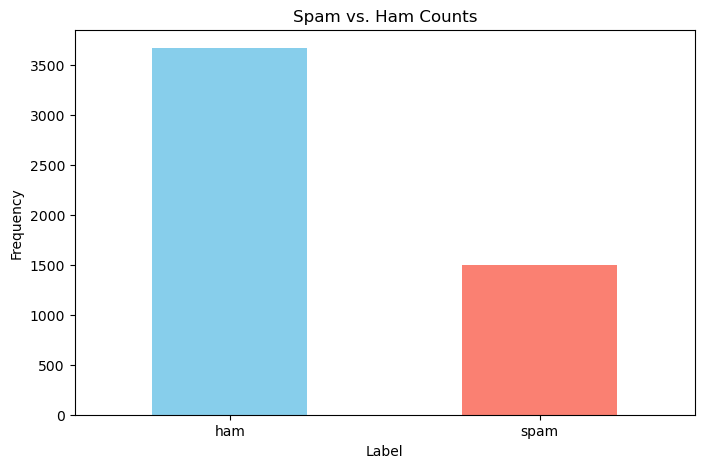

In [85]:
spam_ham_counts = dados['label'].value_counts()
plt.figure(figsize=(8, 5))
spam_ham_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Spam vs. Ham Counts')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

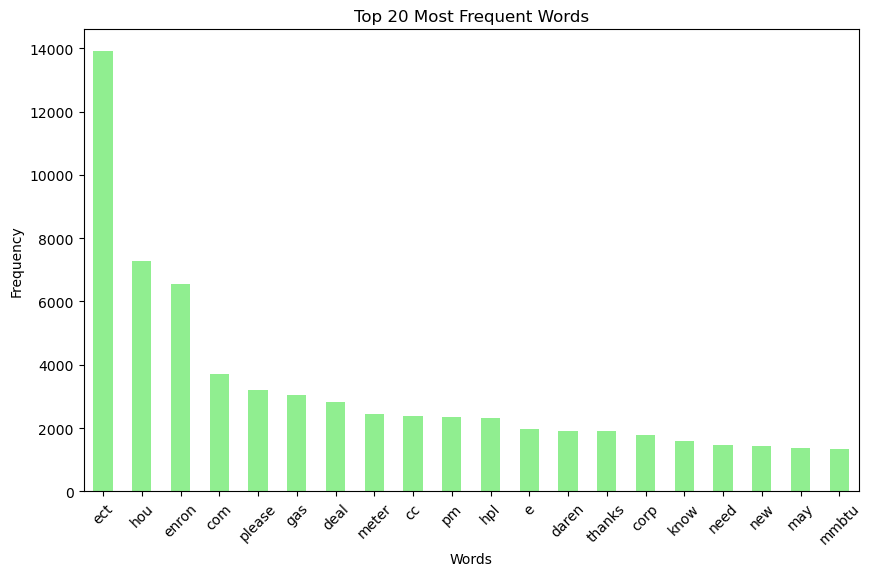

In [86]:
all_words = ' '.join(dados['text']).split()
word_freq = pd.Series(all_words).value_counts().head(20)


plt.figure(figsize=(10, 6))
word_freq.plot(kind='bar', color='lightgreen')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [87]:
X = dados['text']
y = dados['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=60)

X_train.head()

5104     fw ercot link ercot page original message ima...
3153     teco trading conf call monday conference room...
4606     brandywine meter march activity longer standb...
2205     explore good featured super viagrla valerie i...
2314     meter acock production spoken clem meter non ...
Name: text, dtype: object

In [88]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [89]:
print(X_train_tfidf_df.shape)

(3878, 38382)


In [90]:
modelo = RandomForestClassifier(random_state=60)
param_distributions = {
    'n_estimators': [235, 240, 245],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [7, 8, 9],
    'min_samples_leaf': [2, 3, 4],
    'bootstrap': [True, False]
}

In [91]:
random_search = RandomizedSearchCV(
    estimator=modelo,
    param_distributions=param_distributions,
    n_iter=50,  
    scoring='accuracy',
    cv=3,  
    verbose=3,
    random_state=60,
    n_jobs=-1  
)

In [92]:

print("\nTuning hyperparameters with RandomizedSearchCV...")
random_search.fit(X_train_tfidf, y_train)

print("\nBest Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)




Tuning hyperparameters with RandomizedSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best Parameters: {'n_estimators': 245, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
Best Cross-Validation Accuracy: 0.9793703413713758


In [93]:
modelo_final = random_search.best_estimator_
modelo_final.fit(X_train_tfidf, y_train)


y_pred = modelo_final.predict(X_test_tfidf)



Test Accuracy with Tuned Model: 0.979891724671307


In [96]:


print("\nTest Accuracy with Tuned Model:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy with Tuned Model: 0.979891724671307

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       913
           1       0.95      0.99      0.97       380

    accuracy                           0.98      1293
   macro avg       0.97      0.98      0.98      1293
weighted avg       0.98      0.98      0.98      1293


Confusion Matrix:
 [[892  21]
 [  5 375]]
